<a href="https://colab.research.google.com/github/Teerapatt6/E-commerce-Price-Analytics/blob/main/notebooks/model/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install pandas

In [15]:
import pandas as pd

In [16]:
df = pd.read_csv('./s24_price_in_thb.csv', parse_dates=['date'])
df['date'] = pd.to_datetime(df['date'])
df['price_thb'] = pd.to_numeric(df['price_thb'], errors='coerce')
df['price_thb'].interpolate(method='linear', inplace=True)


/tmp/ipython-input-4142651125.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['price_thb'].interpolate(method='linear', inplace=True)


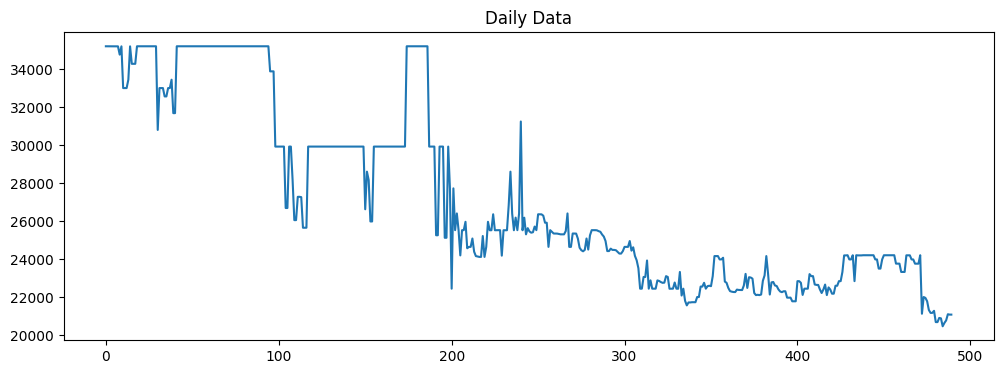

In [17]:
import matplotlib.pyplot as plt
df['price_thb'].plot(figsize=(12,4))
plt.title("Daily Data")
plt.show()

In [50]:
def create_lags(data, n_lags=5):
    df_lag = pd.DataFrame()
    for i in range(1, n_lags+1):
        df_lag[f'lag_{i}'] = data.shift(i)
    df_lag['price_thb'] = data
    df_lag = df_lag.dropna()
    return df_lag

n_lags = 20
df_features = create_lags(df['price_thb'], n_lags)

X = df_features.drop('price_thb', axis=1).values
y = df_features['price_thb'].values

In [51]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [52]:
train_size = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param_grid = {
    'C': [1, 10, 100],
    'gamma': [0.01, 0.1, 1],
    'epsilon': [0.01, 0.1]
}

svr = SVR(kernel='rbf')
grid = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)

Best params: {'C': 100, 'epsilon': 0.1, 'gamma': 0.01}


In [54]:
from sklearn.svm import SVR

# SVR with RBF kernel (good for non-linear patterns)
svr_model = SVR(kernel='rbf', C=100, gamma=0.01, epsilon=0.1)
svr_model.fit(X_train, y_train)

SVR(C=100, gamma=0.01)

In [55]:
y_pred = svr_model.predict(X_test)

In [56]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred)/y_test)) * 100

print(f"MAE: {mae}, RMSE: {rmse}, MAPE: {mape:.2f}%")

MAE: 827.9180964560197, RMSE: 1122.5029169463933, MAPE: 3.77%


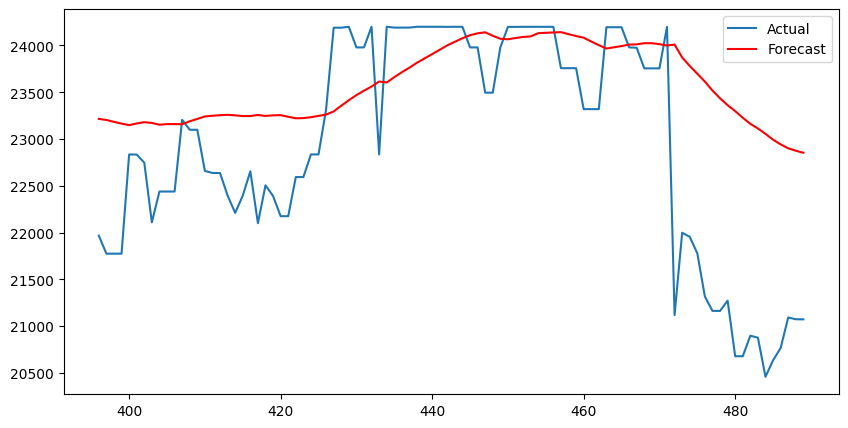

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(df.index[-len(y_test):], y_test, label='Actual')
plt.plot(df.index[-len(y_test):], y_pred, label='Forecast', color='red')
plt.legend()
plt.show()